<a href="https://colab.research.google.com/github/zahraDehghanian97/Self_Organizing_Map/blob/master/SOFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **prerequisit**

In [96]:
try :
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from PIL import Image
import glob
import pickle
import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


## mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **make dataset ready**

In [97]:
def load_photos(dir_name):
    photo_list =[]
    labels = []
    for file_name in (glob.glob(dir_name+'/*')):
        image = Image.open(file_name)
        image = np.array(image).flatten()
        photo_list.append(image)
        x = file_name.split('/')
        labels.append(x[6].split('.')[1])
    photo_list = np.array(photo_list)
    photo_list = np.array(preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(photo_list))
    unique_value =list(set(labels))
    y = []
    for label in labels :
      y.append(unique_value.index(label))
    return photo_list , unique_value , y 
  
    

dir_name = "/content/drive/MyDrive/Colab Notebooks/yalefaces"
X , unique_value , y= load_photos(dir_name) 
n_features =len(X[0])
n_classes = len(unique_value)
print(n_classes)
print(X[0])
print(n_features)
print(y)



11
[1. 1. 1. ... 0. 0. 0.]
77760
[2, 7, 10, 6, 0, 9, 5, 4, 8, 3, 1, 7, 2, 10, 6, 0, 9, 4, 5, 3, 8, 1, 7, 10, 2, 6, 9, 0, 4, 5, 3, 8, 1, 7, 10, 2, 6, 0, 4, 9, 3, 8, 1, 7, 2, 10, 6, 0, 4, 9, 3, 5, 8, 7, 1, 2, 10, 6, 0, 4, 9, 5, 8, 3, 1, 7, 2, 10, 6, 0, 4, 9, 5, 3, 8, 1, 7, 2, 6, 10, 0, 4, 9, 5, 8, 3, 1, 2, 7, 10, 0, 6, 4, 9, 5, 3, 1, 8, 2, 7, 10, 0, 6, 9, 5, 4, 3, 1, 8, 7, 2, 10, 6, 0, 9, 5, 4, 3, 8, 1, 7, 2, 10, 6, 9, 0, 5, 4, 3, 1, 8, 7, 2, 10, 6, 9, 0, 4, 5, 3, 8, 1, 7, 10, 2, 6, 0, 9, 5, 4, 3, 1, 8, 7, 2, 10, 0, 6, 9, 5, 4, 3, 1, 8, 5]


# **SOM Class**

load map finished
[[7. 6. 2. 4.]
 [0. 6. 7. 8.]
 [5. 5. 0. 4.]
 [4. 0. 7. 0.]]


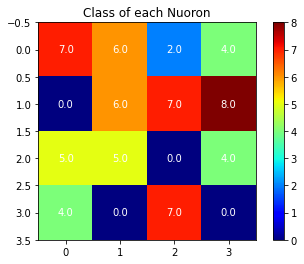

Meaning of each number :
0 : noglasses   1 : wink   2 : glasses   3 : sleepy   4 : rightlight   5 : sad   6 : leftlight   7 : centerlight   8 : surprised   9 : normal   10 : happy   
Accuracy founded map = 0.0967


In [98]:
class SOM:
    def __init__(self,data, map_size,dir_map="not load from file", lr = 0.05):
        self.map = np.zeros(shape=map_size)
        ind = np.random.choice(data.shape[0],(map_size[0], map_size[1]) , replace=False)
        for i in range(map_size[0]):
          for j in range (map_size[1]):
            self.map[i,j] = data[ind[i,j]]
        self.lr0 = lr
        self.lr = self.lr0
        self.R0 = map_size[0]//2
        self.R = self.R0
        if dir_map != "not load from file":
          self.load_map(dir_map)
    
    def load_map(self,dir_map):
        with open(dir_map, "rb") as f:
            self.map = pickle.load(f)
        print("load map finished")

        
    def train(self, X, y,dir_map, T=1000, error_threshold=10**-20): 
        Js = []
        for t in range(T):
            prev_map = np.copy(self.map)
            shuffle_ind = np.random.randint(low=0, high=len(X), size=len(X))  # a vector of random indices
            for i in range(len(X)):
                x = X[shuffle_ind[i],:]
                x = np.asarray(x)
                winner = self.find_winner(x)    # winner = [1,4]
                NS = self.get_NS(winner)
                self.update_weights(x, NS, len(X))
            self.lr = self.lr0 * (1 - t/T)
            self.R = self.R0 * (1 - t/T)
            Js.append(np.linalg.norm(prev_map - self.map))     # norm of changes
            if t % 10 == 0:
                print('Iteration: %d, LR: %f, R: %f, J: %f' %(t, self.lr, self.R, Js[-1]))
                # self.visualize(X, y)
            if t % 50 == 0:
                with open(dir_map, 'wb') as f:  
                    pickle.dump(self.map, f)
            if Js[-1] < error_threshold:
                print('Min changes')
                break
        # save founded model at last
        with open(dir_map, 'wb') as f:  
          pickle.dump(self.map, f)

        return Js
            
    def find_winner(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis=2)   
        winner = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
        return winner
    
    def get_NS(self, winner):
        # not neighbor = 0 , neighbor = 1/sqrt(euclidean_distance)
        NS = np.zeros(shape= (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if (0 <= iw + ri < self.map.shape[0]) and  (0 <= jw + rj < self.map.shape[1]):   
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(ri**2 + rj**2) > R else 1/ ( 1+ np.sqrt(ri**2 + rj**2))  
        return NS
    
    def update_weights(self, x, n_strength, X_len):
        NS = np.tile(n_strength, [self.map.shape[2],1,1]).transpose()
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        Delta = rep_x - self.map 
        self.map = self.map + (self.lr/X_len) * np.multiply(NS, Delta)

    def visualize(self, X, y):
        scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1],len(list(set(y)))))  
        self.scores = np.zeros(shape=(self.map.shape[0], self.map.shape[1]))  
        for i in range(len(X)):
            x = X[i, :]
            x = np.asarray(x)
            winner = self.find_winner(x)
            iw, jw = winner[0], winner[1]
            scores[iw, jw][y[i]] += 1
        for i in range(len(scores)):
            for j in range(len(scores[0])):
              self.scores[i,j] = np.argmax(scores[i,j])
        print(self.scores)
        c = plt.imshow(self.scores, cmap='jet')
        plt.colorbar(c)
        for i in range(len(scores)):
          for j in range(len(scores[0])):
            plt.text(j,i, self.scores[i, j],ha="center", va="center", color="w")
        plt.title("Class of each Nuoron")
        plt.show()

    def extract_feature(self, x): # here we give a data of n feature and take a matrix of size map as output (e.g, 9*9)
        x = np.asarray(x)
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[0], 1])
        dists = np.sum((self.map - rep_x)**2, axis=2)
        return 1/ (1 + dists)
    
    def compute_score(self, X, y):
      y_pred = []
      for x in X :
        index = self.find_winner(x)
        y_pred.append(self.scores[index[0],index[1]])
      return accuracy_score(y,y_pred)


m_size = 4
dir_map = '/content/drive/MyDrive/Colab Notebooks/map'+str(m_size)+'*'+str(m_size)+'.txt'

# # train SOM Net
# som_net = SOM(data = X,dir_map = dir_map,map_size = [m_size,m_size,n_features])
# Js = som_net.train(X, y,dir_map, T = 500)
# plt.plot(Js)
# plt.show()

# reload saved model 
som_net = SOM(data = X,dir_map = dir_map,map_size = [m_size,m_size,n_features])

# visualize founded Neurons
som_net.visualize(X, y)
print("Meaning of each number :")
s = ""
for i in range(len(unique_value)):
  s = s + str(i) + " : "+unique_value[i]+"   "
print(s)

# print accuracy founded model
print("Accuracy founded map = "+str(round(som_net.compute_score(X,y),3)))


# **Dimension Reduction**

Dimension Reduction is finished


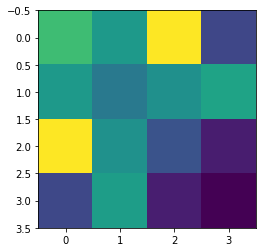

In [90]:
# creating new data by using som feature
new_X = []
for i in range(X.shape[0]):
  x = X[i,:]
  features = som_net.extract_feature(x)
  tmp_data = features .flatten()
  new_X.append(tmp_data)
new_X = np.array(new_X)
print("Dimension Reduction is finished")

# show one of result
x = X[0,:]
features = som_net.extract_feature(x)
plt.imshow(features)
plt.show()


# **Classification with MLP**

make data ready

In [91]:
def convert_into_map(X) :
  new_X = []
  for i in range(X.shape[0]):
    x = X[i,:]
    features = som_net.extract_feature(x)
    tmp_data = features .flatten()
    new_X.append(tmp_data)
  new_X = np.array(new_X)
  return new_X

def plot_result(history):
  # plot model accuracy and loss 
  # accuracy
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('sparse categorical accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
new_X_train = convert_into_map(X_train)
new_X_test = convert_into_map(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

result for reduced data

In [93]:
# create model
model = keras.models.Sequential()
model.add(keras.Input(shape=(new_X_train.shape[1],)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(unique_value), activation='softmax'))
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.summary()
# Training model
history = model.fit(new_X_train, y_train,verbose=0, batch_size=5, epochs= 1000, validation_split= 0.18)
# Predicting labels
y_prob = model.predict(new_X_test)
y_pred = []
for y in y_prob:
  y_pred.append(np.where(y ==(max(y)))[0][0])
print("Accuracy reduced model : "+str(accuracy_score(y_test,y_pred)))

# # plot result
# plot_result(history)


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 100)               1700      
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 30)                3030      
_________________________________________________________________
dropout_22 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 11)                341       
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
Accuracy reduced model : 0.212


result for real data

In [94]:
# create model
model = keras.models.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(unique_value), activation='softmax'))
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.summary()
# Training model
# history = model.fit(X_train, y_train,verbose=0, batch_size=5, epochs= 200, validation_split= 0.18)
# Predicting labels
y_prob = model.predict(X_test)
y_pred = []
for y in y_prob:
  y_pred.append(np.where(y ==(max(y)))[0][0])
print("Accuracy normal model : "+str(accuracy_score(y_test,y_pred)))
# # plot result
# plot_result(history)


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 100)               7776100   
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 30)                3030      
_________________________________________________________________
dropout_24 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 11)                341       
Total params: 7,779,471
Trainable params: 7,779,471
Non-trainable params: 0
_________________________________________________________________
Accuracy normal model : 0.09
